In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
# import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict
from tqdm import tqdm

import polars as pl

In [2]:
from monk import utils, workflow

parent = pathlib.Path(os.getcwd()).parent.parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [90]:
ts = [0.0019836, 0.019836, 0.049591, 0.19836]
t = ts[2]
s = 0.05

In [91]:
output = defaultdict(list)

dataset = None

for job in project:
    print(job)
    prep = job.sp["prep"]
    print(prep)

    if prep != "HTL":
        continue

    expers = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in tqdm(expers):
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        out_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"

        if sp.max_shear != s or sp.temp != t: # 0.19836:
            continue

        traj = gsd.hoomd.open(exper, "rb")

        if job.isfile(out_path):
            dataset = pl.read_parquet(job.fn(out_path), columns=["frame_i", "frame_j", "msd"], use_pyarrow=True)
            dataset = dataset.filter(pl.col("frame_i") == 2039)
            # dataset.drop_in_place("msd")
            # dataset.drop_in_place("id")
            output[sp].append(dataset)
        break
        

    if dataset is not None:
        break
    # break

634e14bc75836df75158fb15f379d8bb
HTL


 52%|█████▏    | 28/54 [00:00<00:00, 86.19it/s]


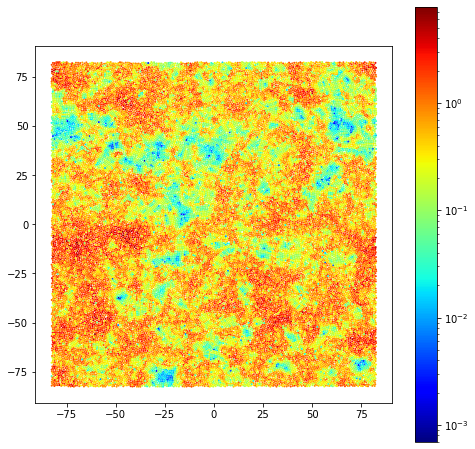

In [92]:
# plot the msd with the positions

fig = plt.figure(figsize=(8, 8))
# set aspect 1
plt.gca().set_aspect('equal', adjustable='box')

row = dataset[-1]

frame = row["frame_j"][0]
frame_i = row["frame_i"][0]
msd = row["msd"][0]

snap = traj[int(frame)]

pos = snap.particles.position

orig_snap = traj[int(frame_i)]
orig_pos = orig_snap.particles.position

query = freud.locality.AABBQuery.from_system(orig_snap)
nlist = query.query(orig_pos, dict(r_max=2.0)).toNeighborList()

# disp = np.sqrt(msd).to_numpy()

box = freud.Box.from_box(orig_snap.configuration.box)

disp = box.wrap(pos - orig_pos)
mdisp = np.zeros_like(disp)

for idx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
    idxs = nlist.point_indices[seg:seg+nn]
    mean_disp = np.mean(disp[idxs], axis=0)
    mdisp[idx] = mean_disp

disp = np.linalg.norm(disp - mdisp, axis=1)

# query = freud.locality.AABBQuery.from_system(orig_snap)
# nlist = query.query(orig_pos, dict(r_max=1.0)).toNeighborList()

# disp = np.sqrt(msd).to_numpy()

# neigh_disp = np.zeros_like(disp)
# for idx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
#     neigh_disp[idx] = np.mean(disp[seg:seg+nn])

# disp = disp - neigh_disp

norm = colors.LogNorm()

plt.scatter(orig_pos[:, 0], orig_pos[:, 1], c=disp, cmap="jet", norm=norm, s=1)
plt.colorbar()

pos_htl = orig_pos
disp_htl = disp

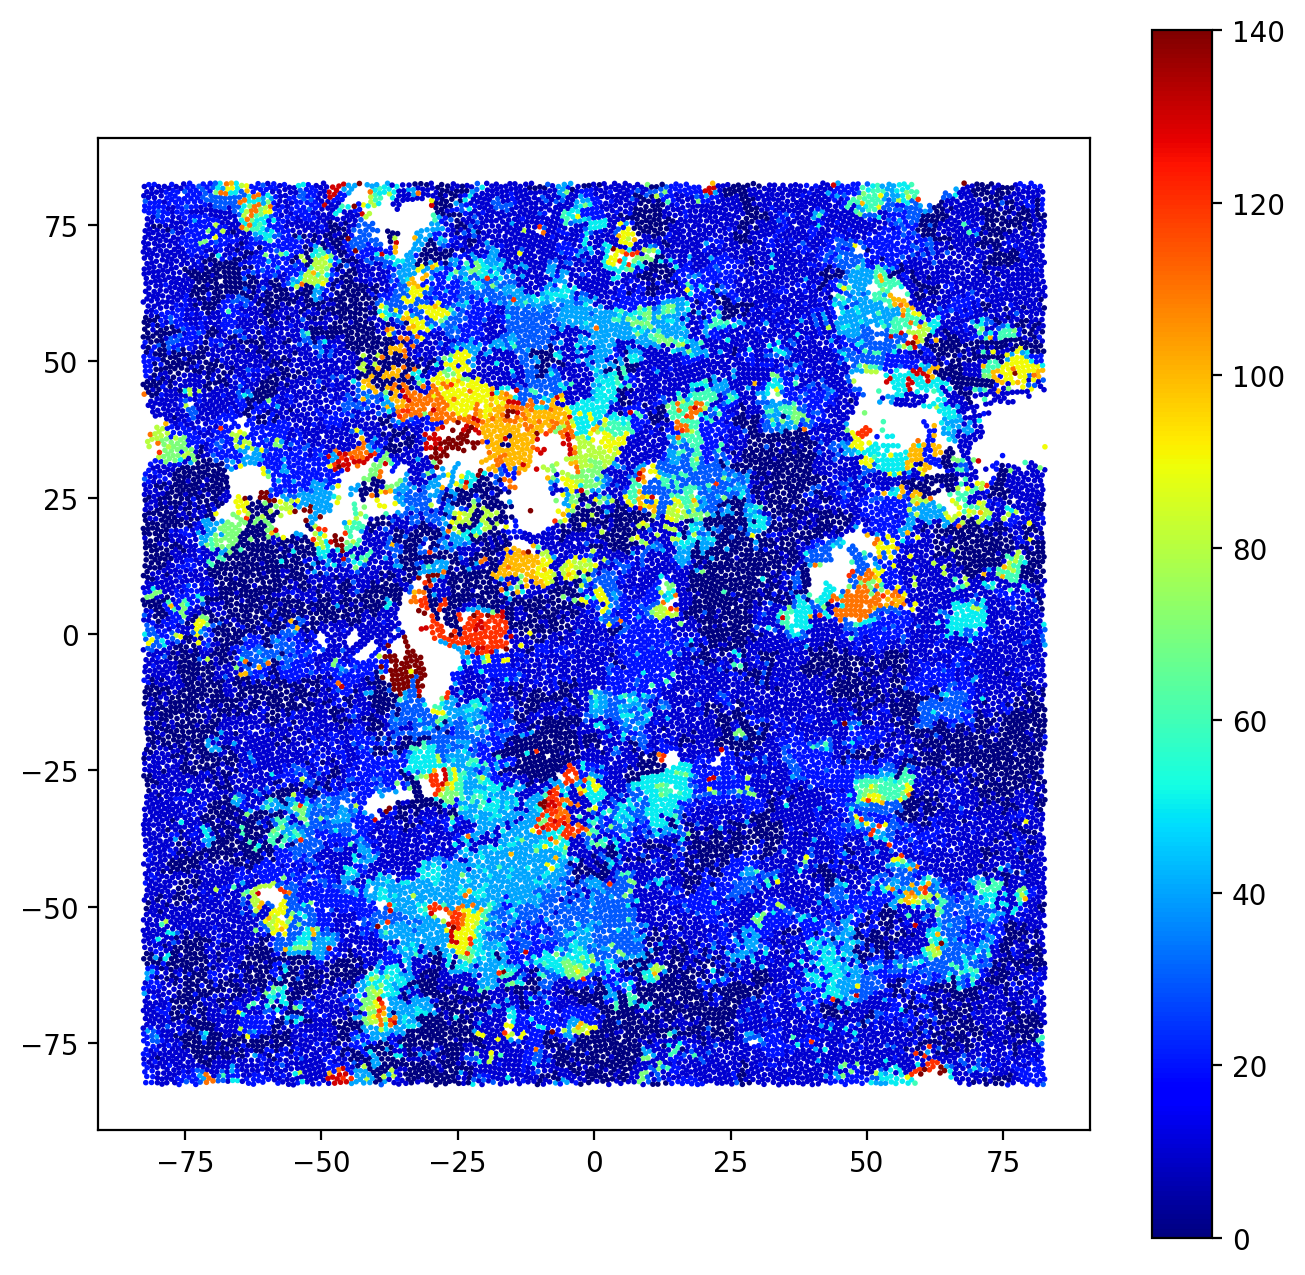

In [94]:
# plot the msd with the positions

fig = plt.figure(figsize=(8, 8), dpi=200)
# set aspect 1
plt.gca().set_aspect('equal', adjustable='box')

N = traj[0].particles.N

t_rearrange =  np.nan * np.ones(N)

for idx in range(len(dataset))[::10]:

    row = dataset[idx]

    frame = row["frame_j"][0]
    frame_i = row["frame_i"][0]
    # print(frame, frame_i)
    msd = row["msd"][0]

    snap = traj[int(frame)]

    pos = snap.particles.position

    orig_snap = traj[int(frame_i)]
    orig_pos = orig_snap.particles.position

    query = freud.locality.AABBQuery.from_system(orig_snap)
    nlist = query.query(orig_pos, dict(r_max=2.0)).toNeighborList()

    # disp = np.sqrt(msd).to_numpy()

    box = freud.Box.from_box(snap.configuration.box)

    disp = box.wrap(pos - orig_pos)
    mdisp = np.zeros_like(disp)

    for jdx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
        idxs = nlist.point_indices[seg:seg+nn]
        mean_disp = np.mean(disp[idxs], axis=0)
        mdisp[jdx] = mean_disp

    disp = np.linalg.norm(disp - mdisp, axis=1)
    
    t_rearrange[(disp > 0.1) & (np.isnan(t_rearrange))] = idx

# neigh_disp = np.zeros_like(disp)
# for idx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
#     neigh_disp[idx] = np.mean(disp[seg:seg+nn])

# disp = disp - neigh_disp

norm2 = colors.Normalize()

plt.scatter(pos[:, 0], pos[:, 1], c=t_rearrange, cmap="jet", norm=norm2, s=1)
plt.colorbar()

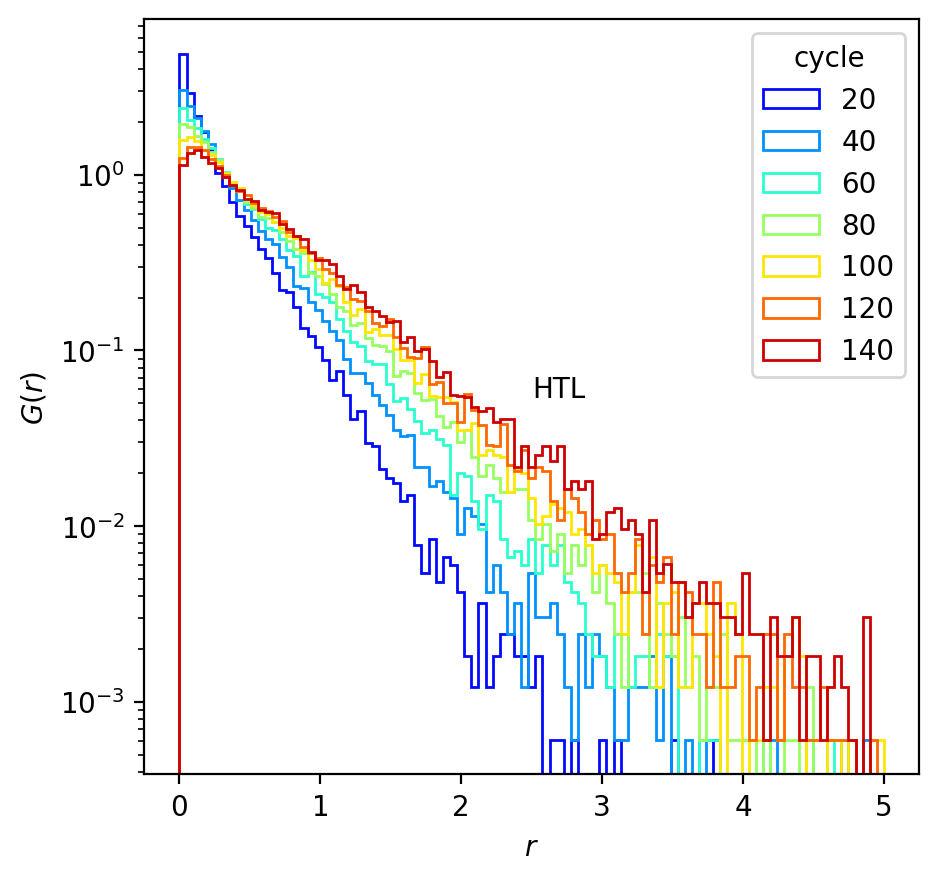

In [93]:
# plot the msd with the positions

fig = plt.figure(figsize=(5, 5), dpi=200)
fig.set_facecolor('white')
# set aspect 1
# plt.gca().set_aspect('equal', adjustable='box')

N = traj[0].particles.N

hnorm = colors.Normalize(vmin=0, vmax=150)
cmap = cm.jet

for idx in range(len(dataset))[20::20]:

    row = dataset[idx]

    frame = row["frame_j"][0]
    frame_i = row["frame_i"][0]
    # print(frame, frame_i)
    msd = row["msd"][0]

    snap = traj[int(frame)]

    pos = snap.particles.position

    orig_snap = traj[int(frame_i)]
    orig_pos = orig_snap.particles.position

    query = freud.locality.AABBQuery.from_system(orig_snap)
    nlist = query.query(orig_pos, dict(r_max=2.0)).toNeighborList()

    # disp = np.sqrt(msd).to_numpy()

    box = freud.Box.from_box(snap.configuration.box)

    disp = box.wrap(pos - orig_pos)
    mdisp = np.zeros_like(disp)

    for jdx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
        idxs = nlist.point_indices[seg:seg+nn]
        mean_disp = np.mean(disp[idxs], axis=0)
        mdisp[jdx] = mean_disp

    disp = np.linalg.norm(disp - mdisp, axis=1)
    
    plt.hist(disp, bins=np.linspace(0, 5, 100), histtype="step", color=cmap(hnorm(idx)), density=True, label=f"{idx}")
plt.yscale('log')
plt.text(0.5, 0.5, "HTL", transform=plt.gca().transAxes)
plt.ylabel(r"$G(r)$")
plt.xlabel(r"$r$")
plt.legend(title="cycle")

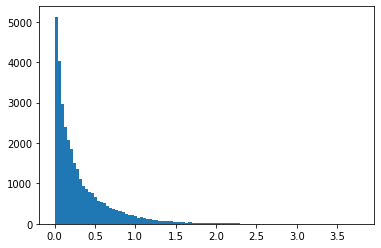

In [13]:
plt.hist(disp, bins=100);

In [95]:
output = defaultdict(list)

dataset = None

for job in project:
    print(job)
    prep = job.sp["prep"]
    print(prep)

    if prep != "ESL":
        continue

    expers = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in tqdm(expers):
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        out_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"

        if sp.max_shear != s or sp.temp != t: # 0.19836:
            continue

        traj = gsd.hoomd.open(exper, "rb")

        if job.isfile(out_path):
            dataset = pl.read_parquet(job.fn(out_path), columns=["frame_i", "frame_j", "msd"], use_pyarrow=True)
            dataset = dataset.filter(pl.col("frame_i") == 2039)
            # dataset.drop_in_place("plt.hist(t_rearrange)t)
        break
        

    if dataset is not None:
        break
    # break

634e14bc75836df75158fb15f379d8bb
HTL
7ec2f6aca035e69077eab24383a21cb6
ESL


 52%|█████▏    | 28/54 [00:00<00:00, 80.26it/s]


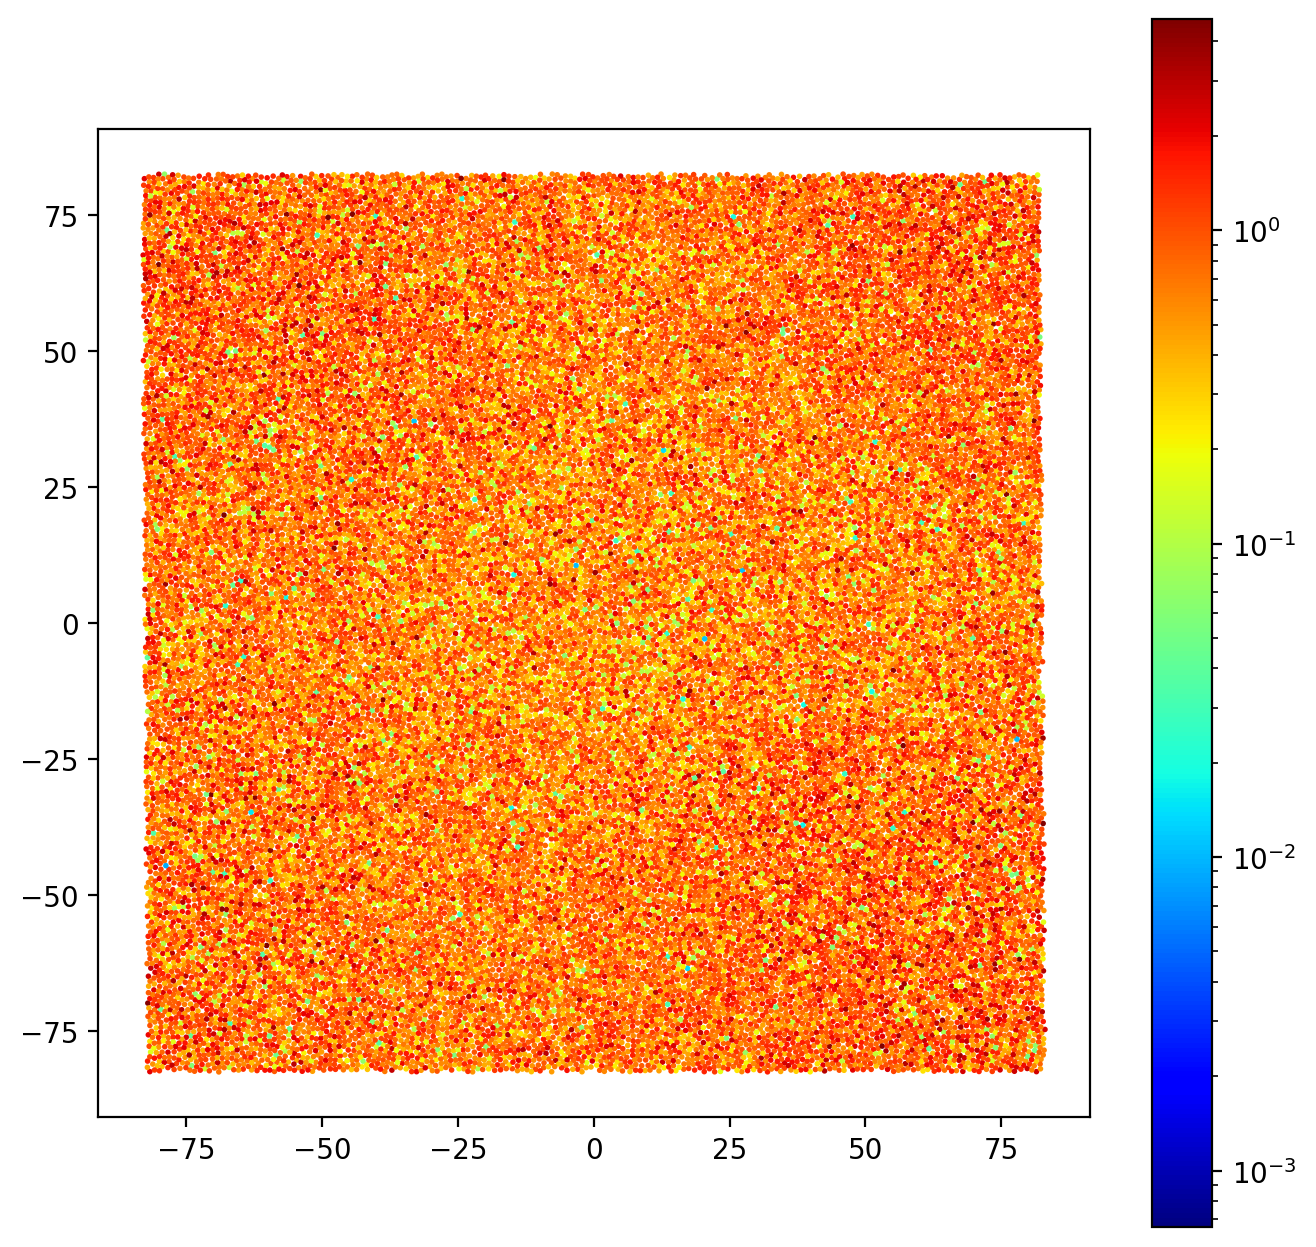

In [86]:
# plot the msd with the positions

fig = plt.figure(figsize=(8, 8), dpi=200)
# set aspect 1
plt.gca().set_aspect('equal', adjustable='box')

row = dataset[-1]

frame = row["frame_j"][0]
frame_i = row["frame_i"][0]
# msd = row["msd"][0]

snap = traj[int(frame)]

pos = snap.particles.position

orig_snap = traj[int(frame_i)]
orig_pos = orig_snap.particles.position

disp = np.sqrt(msd).to_numpy()


plt.scatter(orig_pos[:, 0], orig_pos[:, 1], c=disp, cmap="jet", norm=norm, s=1)
plt.colorbar()

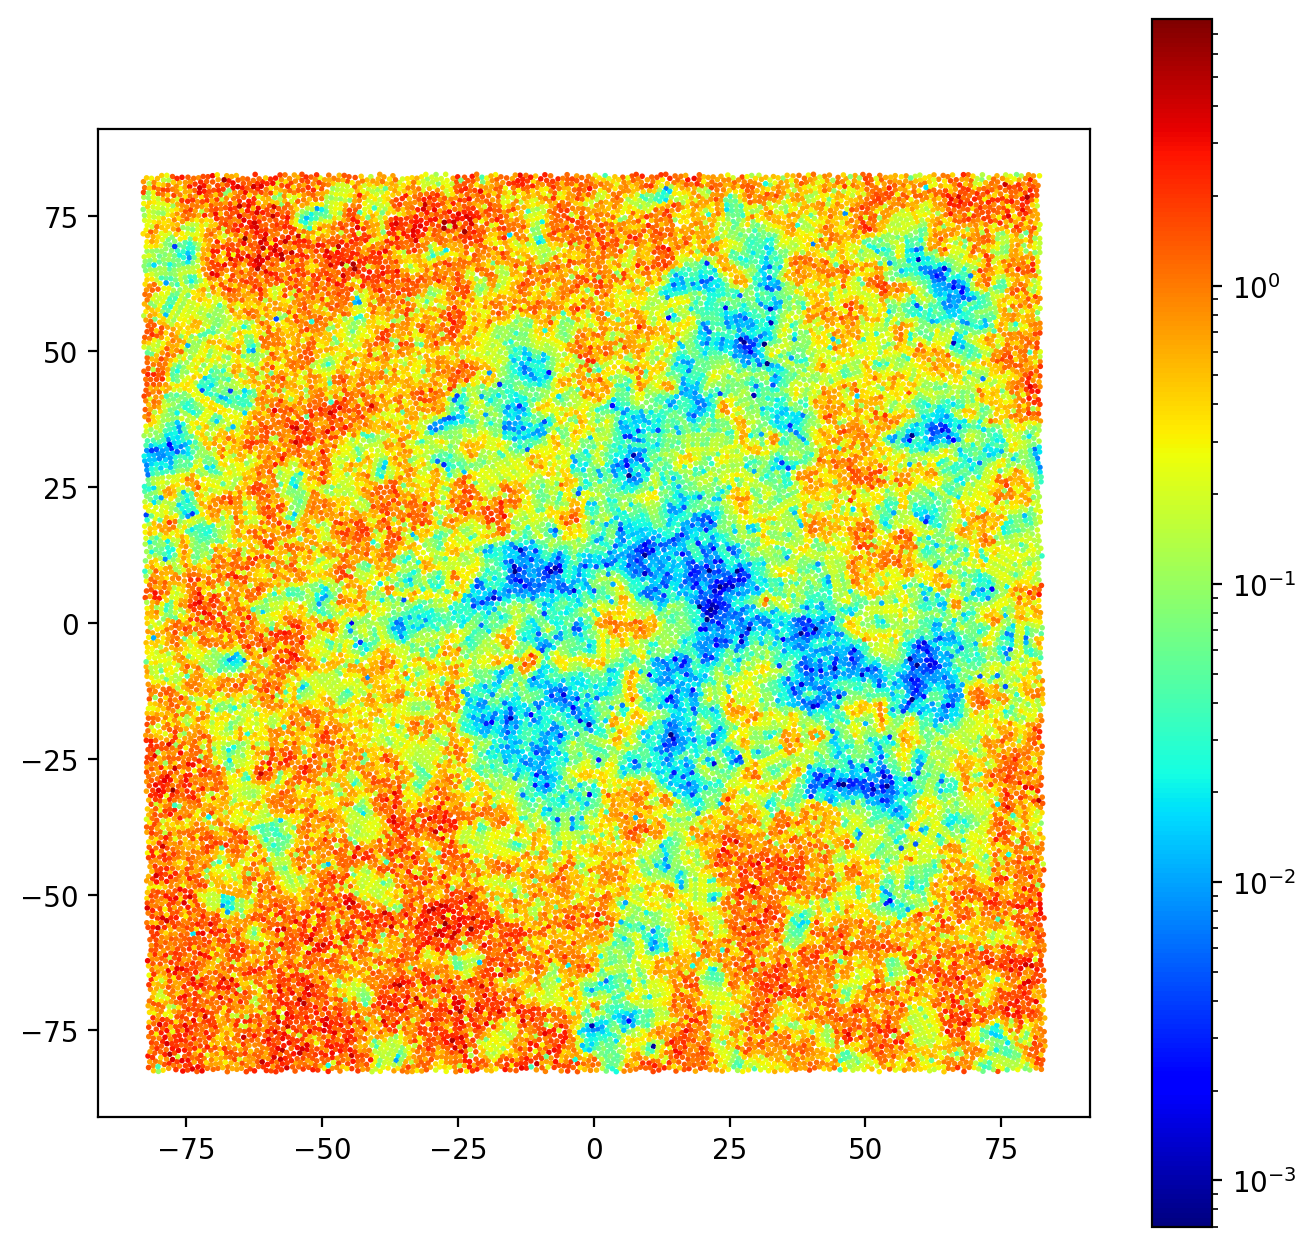

In [96]:
# plot the msd with the positions

fig = plt.figure(figsize=(8, 8), dpi=200)
# set aspect 1
plt.gca().set_aspect('equal', adjustable='box')

row = dataset[-1]

frame = row["frame_j"][0]
frame_i = row["frame_i"][0]
# msd = row["msd"][0]

snap = traj[int(frame)]

pos = snap.particles.position

orig_snap = traj[int(frame_i)]
orig_pos = orig_snap.particles.position

query = freud.locality.AABBQuery.from_system(orig_snap)
nlist = query.query(orig_pos, dict(r_max=1.5, exclude_ii=True)).toNeighborList()

# disp = np.sqrt(msd).to_numpy().copy()

box = freud.Box.from_box(orig_snap.configuration.box)

disp = box.wrap(pos - orig_pos)
mdisp = np.zeros_like(disp)

for idx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
    idxs = nlist.point_indices[seg:seg+nn]
    mean_disp = np.mean(disp[idxs], axis=0)
    mdisp[idx] = mean_disp

disp = np.linalg.norm(disp - mdisp, axis=1)
# disp[disp < 0.5] = 0.0001
# disp[disp >= 0.5] = 10.0

# disp[disp < 0.2] = 0.0001
# disp[disp >= 0.2] = 10.0


# norm = colors.LogNorm()


plt.scatter(orig_pos[:, 0], orig_pos[:, 1], c=disp, cmap="jet", norm=norm, s=1)
plt.colorbar()

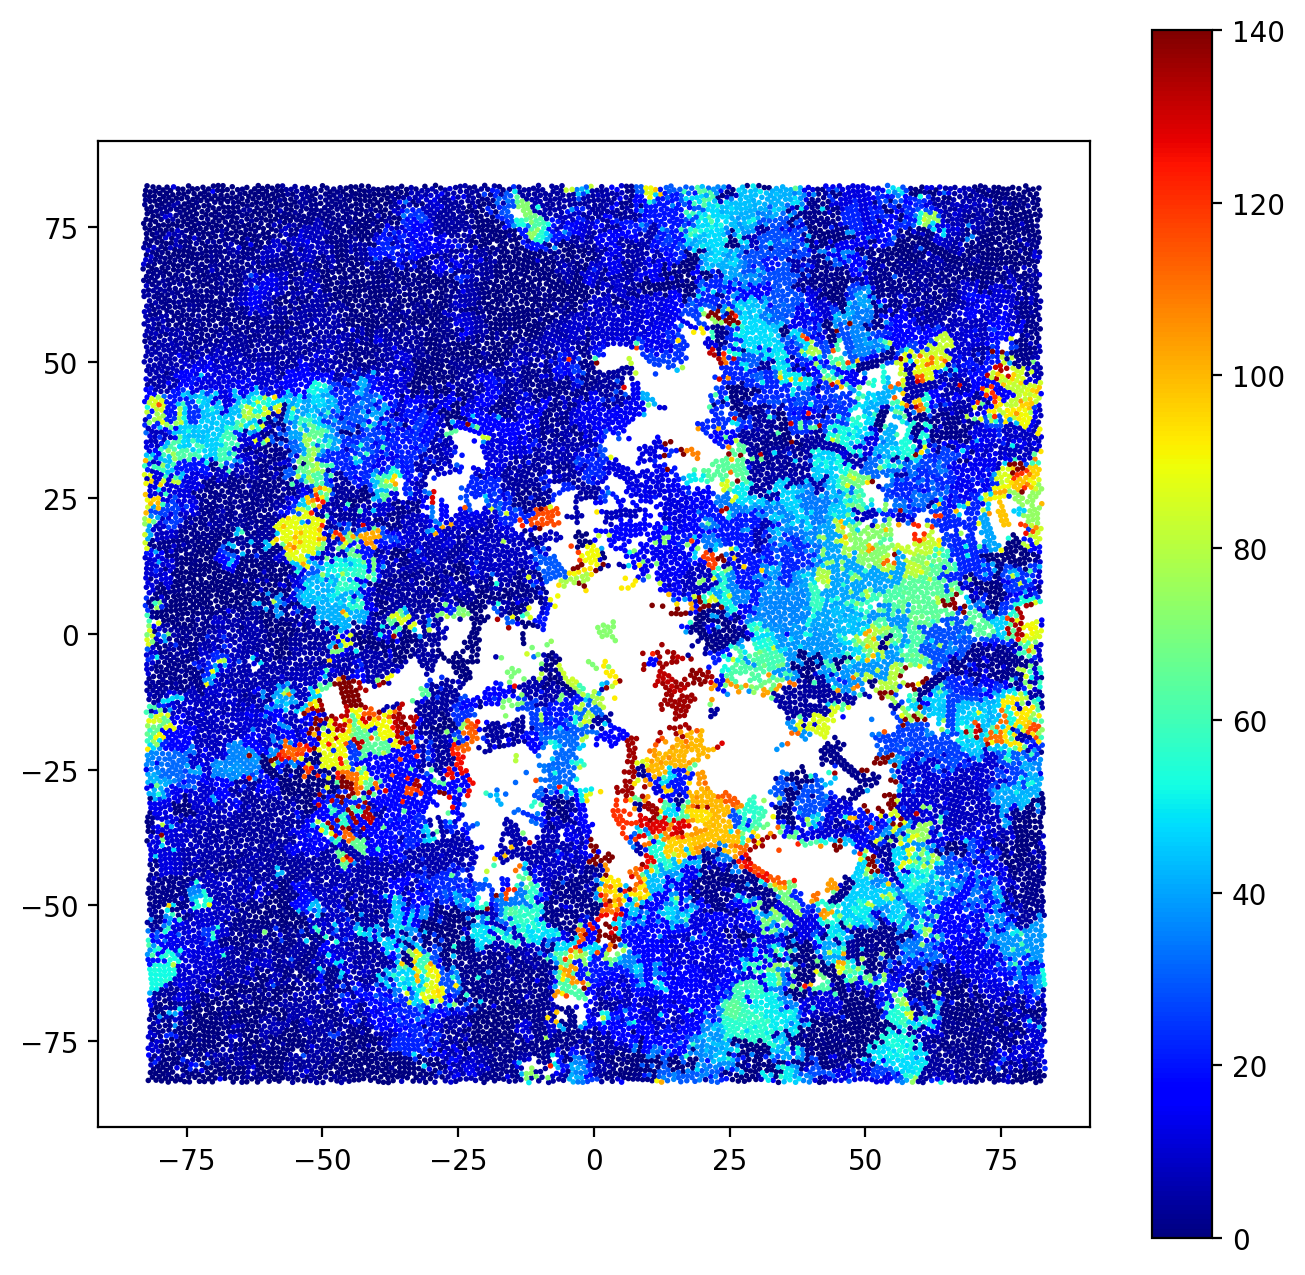

In [97]:
# plot the msd with the positions

fig = plt.figure(figsize=(8, 8), dpi=200)
# set aspect 1
plt.gca().set_aspect('equal', adjustable='box')

N = traj[0].particles.N

t_rearrange =  np.nan * np.ones(N)

for idx in range(len(dataset))[::2]:

    row = dataset[idx]

    frame = row["frame_j"][0]
    frame_i = row["frame_i"][0]
    # print(frame, frame_i)
    msd = row["msd"][0]

    snap = traj[int(frame)]

    pos = snap.particles.position

    orig_snap = traj[int(frame_i)]
    orig_pos = orig_snap.particles.position

    query = freud.locality.AABBQuery.from_system(orig_snap)
    nlist = query.query(orig_pos, dict(r_max=2.0)).toNeighborList()

    # disp = np.sqrt(msd).to_numpy()

    box = freud.Box.from_box(snap.configuration.box)

    disp = box.wrap(pos - orig_pos)
    mdisp = np.zeros_like(disp)

    for jdx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
        idxs = nlist.point_indices[seg:seg+nn]
        mean_disp = np.mean(disp[idxs], axis=0)
        mdisp[jdx] = mean_disp

    disp = np.linalg.norm(disp - mdisp, axis=1)
    
    t_rearrange[(disp > 0.1) & (np.isnan(t_rearrange))] = idx

# neigh_disp = np.zeros_like(disp)
# for idx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
#     neigh_disp[idx] = np.mean(disp[seg:seg+nn])

# disp = disp - neigh_disp

plt.scatter(pos[:, 0], pos[:, 1], c=t_rearrange, cmap="jet", norm=norm2, s=1)
plt.colorbar()

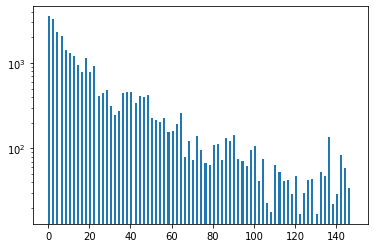

In [101]:
plt.hist(t_rearrange, bins=np.linspace(0, len(dataset), len(dataset)+1))
plt.yscale('log')

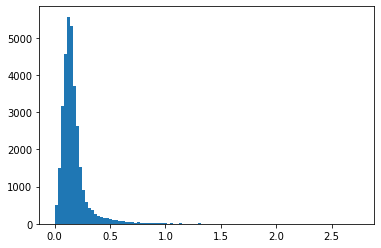

In [118]:
plt.hist(disp, bins=100);

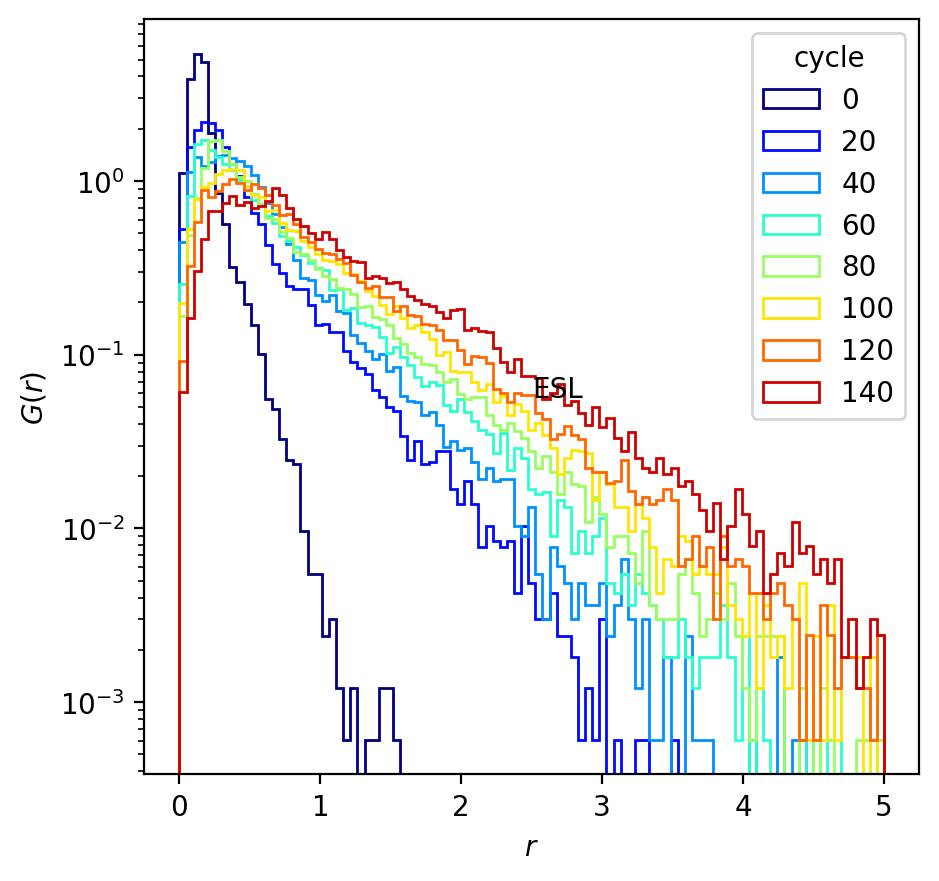

In [99]:
# plot the msd with the positions

fig = plt.figure(figsize=(5, 5), dpi=200)
fig.set_facecolor('white')
# set aspect 1
# plt.gca().set_aspect('equal', adjustable='box')

N = traj[0].particles.N

hnorm = colors.Normalize(vmin=0, vmax=150)
cmap = cm.jet

liss = [0]
liss.extend(range(len(dataset))[20::20])

for idx in liss:

    row = dataset[idx]

    frame = row["frame_j"][0]
    frame_i = row["frame_i"][0]
    # print(frame, frame_i)
    msd = row["msd"][0]

    snap = traj[int(frame)]

    pos = snap.particles.position

    orig_snap = traj[int(frame_i)]
    orig_pos = orig_snap.particles.position

    query = freud.locality.AABBQuery.from_system(orig_snap)
    nlist = query.query(orig_pos, dict(r_max=2.0)).toNeighborList()

    disp = np.sqrt(msd).to_numpy()

    # box = freud.Box.from_box(snap.configuration.box)

    # disp = box.wrap(pos - orig_pos)
    # mdisp = np.zeros_like(disp)

    # for jdx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
    #     idxs = nlist.point_indices[seg:seg+nn]
    #     mean_disp = np.mean(disp[idxs], axis=0)
    #     mdisp[jdx] = mean_disp

    # disp = np.linalg.norm(disp - mdisp, axis=1)
    
    plt.hist(disp, bins=np.linspace(0, 5, 100), histtype="step", color=cmap(hnorm(idx)), density=True, label=f"{idx}")
plt.yscale('log')
plt.text(0.5, 0.5, "ESL", transform=plt.gca().transAxes)
plt.ylabel(r"$G(r)$")
plt.xlabel(r"$r$")
plt.legend(title="cycle")

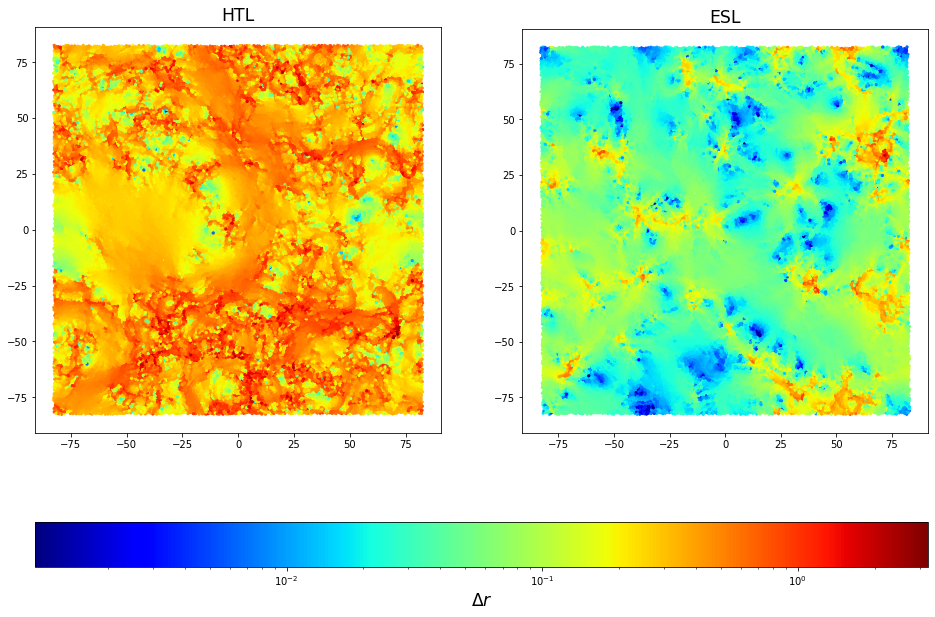

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(16, 11), facecolor="white")
# set aspect 1
for ax in axs:
    ax.set_aspect('equal', adjustable='box')

plt.sca(axs[0])
plt.scatter(pos_htl[:, 0], pos_htl[:, 1], c=disp_htl, cmap="jet", norm=norm, s=5)
plt.title("HTL", size="xx-large")

plt.sca(axs[1])
plt.scatter(pos[:, 0], pos[:, 1], c=disp, cmap="jet", norm=norm, s=5)
plt.title("ESL", size="xx-large")

# make colorbar for the entire figure
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="jet"), ax=axs, orientation="horizontal")
cbar.set_label(r"$\Delta r$", size="xx-large")

plt.savefig("disp-htl-esl-highish-temp.png", dpi=300)